# IMBD Sentimental Analysis Review

## 0. Librerias

Importamos los paquetes que necesitaremos para poder trabajar:

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords

## 1. Carga de datos

Cargamos los datos con los que trabajaremos que será un csv formado por las reviews y su tag en cuanto al sentimiento.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls "drive/MyDrive/ICAI/Análisis de datos no estructurados/Practicas/Texto"

Codigo.ipynb  IMBD_data.csv


In [6]:
!pip install -q tensorboardcolab

In [7]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!nvidia-smi

Sat May 21 08:36:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
reviews = pd.read_csv("drive/MyDrive/ICAI/Análisis de datos no estructurados/Practicas/Texto/IMBD_data.csv")

In [9]:
reviews

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Veamos si nuestros datos estan balanceados:

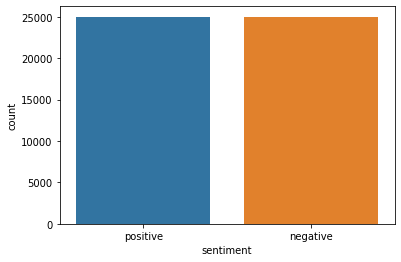

In [10]:
sns.countplot(x = "sentiment", data = reviews)

A su vez cargaremos los datos de las stop words:

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
stopwords = set(stopwords.words('english'))

In [ ]:
print(stopwords)

{"you'll", 'don', 'yourself', "hadn't", 'here', 'off', 'this', 'why', 'some', 'themselves', 'did', 'as', 'have', 'he', 'be', 'to', 'both', 've', 'doesn', 'hadn', 'after', 'each', 'who', 'am', "couldn't", 'for', 'further', 'than', 'you', 'having', 's', 'hers', 'of', 'shan', "wasn't", 'when', 'then', "shan't", 'is', 'ourselves', "shouldn't", 'most', 'we', 'are', 'shouldn', 'on', 'its', 'only', 'during', 'a', 'ours', 'there', 'with', 'that', 'just', 'herself', 'it', "didn't", 'about', 'weren', 'now', 'will', 'yourselves', 'these', 'once', 'no', 'does', "you've", 'couldn', 'what', 'so', "aren't", 'but', 'isn', 'ain', 'has', 'not', 't', 'until', 'him', 'll', "don't", 'she', 'aren', 'wouldn', 'had', 'myself', 'too', "that'll", "it's", 'an', 'other', "mightn't", "needn't", 'hasn', 'didn', 'few', 'were', 'more', 'being', 'himself', 'out', 'doing', 'yours', 'where', 'how', 'through', 'into', 'in', 'below', 'down', 'been', "doesn't", 'whom', 'y', 'your', 'because', 'all', 'theirs', 'needn', 'fro

## 2. Preprocesado

Como se puede ver en el caso que se encuentra abajo, podemos encontrarnos con tags de código html:

In [ ]:
reviews.iloc[1,0]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

Para ello crearemos una función que te permita eliminar todos los tags del código:

In [13]:
def tags_out(review,stopwords):
    review = review.lower()
    review = re.sub('<br />','',review)
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = re.sub(r"\s+[a-zA-Z]\s+", ' ', review)
    for palabra in stopwords:
        review = re.sub(' ' + palabra + ' ',' ', review)
    review = re.sub(r'\s+',' ', review)
    return review

In [11]:
a = reviews.iloc[1,0]

In [ ]:
tags_out(a,stopwords)

'a wonderful little production filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great master comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwell murals decorating every surface terribly well done '

Una vez visto que nuestra función trabaja correctamente vamos a aplicarselo a todas las reviews:

In [14]:
reviews_list = list(reviews['review'])
review_post = [tags_out(review,stopwords) for review in reviews_list]

In [13]:
review_post

['one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skil

Por último pasaremos de string a integer la columna sentimientos:

In [15]:
sentimiento = reviews['sentiment']
sentimiento = np.array(list(map(lambda x: 1 if x=="positive" else 0, sentimiento)))

### Frequency distribution

In [16]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
from nltk.tokenize import word_tokenize

def get_word_tokens(sentences):
    '''Word tokenization'''
    words = []
    for sent in sentences:
        words.extend(word_tokenize(sent))
    print(words)
    return(words)

In [21]:
review_words = get_word_tokens(review_post)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
import matplotlib
from nltk.probability import FreqDist
matplotlib.use('TkAgg')

def plot_freq_dist(words, num_words = 20):
    fdist = FreqDist(words)
    fdist.plot(num_words,cumulative=False)

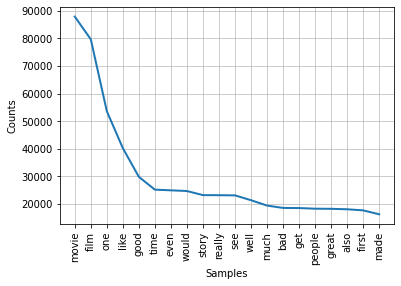

In [22]:
# plot_freq_dist(sample_words, num_words=10)
plot_freq_dist(review_words, num_words=20)

Ahora vamos a ver el tipo de cada palabra

In [23]:
nltk.download('averaged_perceptron_tagger')

def get_pos_tags(words):
    tags=[]
    for word in words:
        tags.append(nltk.pos_tag([word]))
    print(tags)
    return tags

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [24]:
sample_tags = get_pos_tags(review_words)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [43]:
tag_fd = nltk.FreqDist(l[0][1] for l in sample_tags)
tag_fd.most_common()

[('NN', 3041585),
 ('NNS', 690700),
 ('JJ', 563785),
 ('RB', 481518),
 ('VBG', 268763),
 ('VBN', 252163),
 ('VB', 163866),
 ('IN', 112630),
 ('CD', 78481),
 ('VBD', 62301),
 ('MD', 61815),
 ('VBZ', 52276),
 ('DT', 34441),
 ('JJS', 29727),
 ('RBR', 16463),
 ('PRP', 10487),
 ('JJR', 8113),
 ('WP$', 1905),
 ('CC', 1821),
 ('WDT', 1411),
 ('WRB', 1026),
 ('PRP$', 740),
 ('WP', 691),
 ('TO', 244),
 ('VBP', 76),
 ('FW', 7)]

Aquí explicaremos qué es cada tag de los más repetidos:


1.   NN: Noun
2.   NNS: Noun plural
3.   JJ: This NLTK POS Tag is an adjective
4.   RB: Adverb
5.   VGB: Verb gerund
6.   VBN: Verb past participle
7.   VB Verb
8.   IN: Preposition/subordinating conjunction
9.   CD: Cardinal digit
10.  Verb past tense 



Representamos una nube de palabras

In [42]:
import wordcloud
import matplotlib.pyplot as plt

In [40]:
wc2 = wordcloud.WordCloud(
    width=1000, 
    height=1000, 
    stopwords=stopwords,
    max_words=100,
    collocations=False
).generate(text=(' '.join(review_words)).lower())

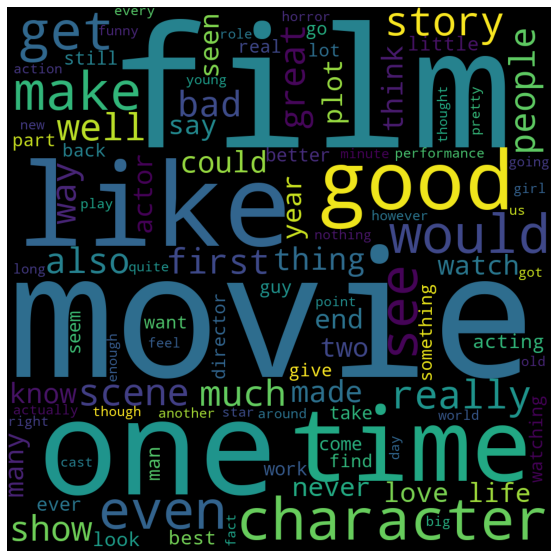

In [43]:
# In[12]:
get_ipython().run_line_magic('matplotlib', 'inline')
plt.figure(figsize=[10,10])
plt.imshow(wc2)
plt.axis("off");